<a href="https://colab.research.google.com/github/alexDahersh/Data-Science-fund./blob/main/AlexHersU5proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [10]:
!pip install "preliz[full,notebook]"

In [11]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm

from scipy.interpolate import PchipInterpolator

import preliz as pz


# Which Political Party is Richer?

I'm going to be looking at how yearly income relates to which political party somebody associates with. The data I'm using gives values for how much somebody associates with the Democratic party and Republican party (from 0-100) so I'll be subtracting them to get their affiliation. For example, say their democratic value is 60 and republican value is 40. The number I'll be looking at is 20. It would be -20 if they were more Republican than Democratic.

I'm going to be modelling the data and provide minimal discussion on why the results are the way they are. I don't know too much about how this works out in real life, so I'm just going to try and model the data. I have enough data (in the 10s of thousands) so this should be fine.



## Assumptions

I know nothing.

Every single prior I'm going to use will be normal or half normal. I'll use high sigmas to show variability.

I'm assuming the mean of poor to middle class people will neither lean strongly Democrat or Republican. The country is split about 50-50 between Republican and Democrat and since poor and middle class people make up most of the population they must be split roughly 50-50.

I'll also be assuming the mean of upper class people doesn't strongly lean Democrat or Republican. I simply have no clue how they lean but I don't think it will be too extreme.

I'll also assume very high variability in political affiliation. I think everything from fully Democrat to fully Republican is possible so all my priors for standard deviation will cover the full range.

## Likelihood

My initial likelihood will be a normal distribution. I doubt a normal distribution will work, so I'll use a beta afterwards.

The main reason I think a beta distribution will perform better is because it has the correct support. A normal distribution just can't perform well because it will be predicting values not even possible. The only reason I'm running a normal model is because it's quick and shouldn't do too bad predicting the mean.

A beta model has support (0,1] so I can multiply by 200 and subtract by 100 to get the correct support (I use 202 and 101 so the model doesn't implode with a 0). Just having the correct support alone will make the model much better. I also think the beta's model variability in shape helps. It can have a mode that is most likely, be uniform, or have an anti mode that looks weird. One of those has to be a decent model of the shape.

Also, because I'm unsure how to use preliz and other libraries entirely, sometimes images, or maybe even my commentary, will show the Beta distribution between 0 and 1. If you ever see this, just know that .5 is no party, 1 is Democratic, and 0 is Republican.

## Priors

### Normal Priors

My priors for my normal likelihood model

I'll of course be running a linear model. I'll start out entirely linear and then, on the off chance it isn't linear, I'll add in a transformation. My first priors will thus be alpha and beta (and a sigma for variability).

My initial priors are for a Beta distribution with paramaters mu and sigma.

Alpha will be distributed by normal(0,20). It follows my assumption that poor people's mean is around 0 (neither Democratic nor Republican) and a sigma of 20 allows for a lot of variability.

In [ ]:
pz.Normal(mu=0,sigma=20).plot_pdf()

Beta will be distributed by normal(0,.0005). It follows my assumption that rich and middle-class people aren't strongly Democrat or Republican. A sigma of .001 seems small but a beta of .0005 will change the mean from being the most extreme Republican to the most extreme Democrat in $400k.

In [ ]:
pz.Normal(mu=0,sigma=.0005).plot_pdf()

Sigma will be distributed by halfnormal(50). A sigma of 50 ensures that the entirety of the political spectrum (from -100 to 100) is still likely. Even if the mean is high or low, the political affiliation

In [ ]:
pz.HalfNormal(50).plot_pdf()

## Data

All data is taken from https://polarizationresearchlab.org

My Data goes from 2022 to 2024 and has around 110 surveys taken weekly. I'll be combining the first 30 surveys together, and then the last 30 surveys together, to try and find relationship between income and political affiation and maybe see if it's changed in two years.



In [3]:
income2022 = []
affiliation2022 = []
income2024 = []
affiliation2024 = []

week = 38 # first week (of 2022) a survey was conducted
year = 2022 # first year a survey was conducted
for i in range(30): # looping through first 30 surveys
  survey_url = "https://raw.githubusercontent.com/alexDahersh/Data-Science-fund./refs/heads/main/s" + str(i+1) + "-" + str(year) + "-week"+str(week)+".csv" # format of the url in github
  data = pd.read_csv(survey_url)

  income = data.faminc_new.to_numpy().tolist()
  income2022 += income

  affiliation = (data.democrat_therm_1 - data.republican_therm_1).to_numpy().tolist()
  affiliation2022 += affiliation


  if (week == 52): # to account for when the year changes
    week = 0
    year += 1
  week += 1


week = 47
year = 2024
for i in range(30): # looping through last 30 surveys
  survey_url = "https://raw.githubusercontent.com/alexDahersh/Data-Science-fund./refs/heads/main/s" + str(114-i) + "-" + str(year) + "-week"+str(week)+".csv" # format of the url in github
  data = pd.read_csv(survey_url)

  income = data.faminc_new.to_numpy().tolist()
  income2024 += income

  affiliation = (data.democrat_therm_1 - data.republican_therm_1).to_numpy().tolist()
  affiliation2024 += affiliation

  week -= 1
  if (i==0 or i==6 or i==9 or i ==13 or i==17 or i==26): # they skipped some weeks
    week -= 1
  if (i==2 or i==8 or i==10 or i==14 or i==20 or i==27):
    week += 1 # they did two in some weeks

In [4]:
income2022

['$120,000 - $149,999',
 '$80,000 - $99,999',
 '$120,000 - $149,999',
 '$60,000 - $69,999',
 '$100,000 - $119,999',
 '$120,000 - $149,999',
 '$80,000 - $99,999',
 '$70,000 - $79,999',
 '$100,000 - $119,999',
 '$100,000 - $119,999',
 'Prefer not to say',
 '$70,000 - $79,999',
 '$20,000 - $29,999',
 '$150,000 - $199,999',
 'Prefer not to say',
 '$10,000 - $19,999',
 '$120,000 - $149,999',
 '$30,000 - $39,999',
 '$40,000 - $49,999',
 '$30,000 - $39,999',
 '$30,000 - $39,999',
 '$20,000 - $29,999',
 '$10,000 - $19,999',
 '$30,000 - $39,999',
 '$50,000 - $59,999',
 '$50,000 - $59,999',
 '$20,000 - $29,999',
 '$50,000 - $59,999',
 'Prefer not to say',
 '$80,000 - $99,999',
 '$20,000 - $29,999',
 '$250,000 - $349,999',
 '$120,000 - $149,999',
 '$120,000 - $149,999',
 '$50,000 - $59,999',
 'Prefer not to say',
 '$60,000 - $69,999',
 '$30,000 - $39,999',
 '$150,000 - $199,999',
 '$200,000 - $249,999',
 '$100,000 - $119,999',
 '$80,000 - $99,999',
 '$120,000 - $149,999',
 '$80,000 - $99,999',
 '

The income data is in the form of strings so the code below converts the strings to ints and identifies people who didn't give their income.



In [5]:
income2022E = [] # E for edited
for inc in income2022:
  if not ('$' in inc): # if there is no number, use -1 for the income
    income2022E.append(-1)
    continue

  i=0 # finds the first value of the range (of money)
  inc2 = ''
  while (inc[i] != '$'):
    i+=1
  i+=1
  while (inc[i].isnumeric() or inc[i] == ','):
    if (inc[i] == ','):
      i+=1
      continue
    inc2 += inc[i]
    if (i < len(inc)-1):
      i+=1
    else:
      break

  i=-1 # finds the last value of the range (of money)
  inc3 = ''
  while (inc[i] != '$'):
    i-=1
  i+=1
  while (inc[i].isnumeric() or inc[i] == ','):
    if (inc[i] == ','):
      i+=1
      continue
    inc3 += inc[i]
    if (i < len(inc)-1):
      i+=1
    else:
      break

  income2022E.append((int(inc2)+int(inc3))/2) # average the first and last value of the range

In [6]:
income2024E = [] # E for edited
for inc in income2024:
  if not ('$' in inc): # if there is no number, use -1 for the income
    income2024E.append(-1)
    continue

  i=0 # finds the first value of the range
  inc2 = ''
  while (inc[i] != '$'):
    i+=1
  i+=1
  while (inc[i].isnumeric() or inc[i] == ','):
    if (inc[i] == ','):
      i+=1
      continue
    inc2 += inc[i]
    if (i < len(inc)-1):
      i+=1
    else:
      break

  i=-1 # finds the last value of the range
  inc3 = ''
  while (inc[i] != '$'):
    i-=1
  i+=1
  while (inc[i].isnumeric() or inc[i] == ','):
    if (inc[i] == ','):
      i+=1
      continue
    inc3 += inc[i]
    if (i < len(inc)-1):
      i+=1
    else:
      break

  income2024E.append((int(inc2)+int(inc3))/2) # average the first and last value of the range

The following code removes unusable data and counts the size of the data

In [7]:
income2022U = [] # U for usable
affiliation2022U = []
for i in range(len(income2022E)): # gets rid of everybody who didn't have an income or party affiliation
  if (income2022E[i] == -1 or np.isnan(affiliation2022[i])):
    continue
  income2022U.append(income2022E[i])
  affiliation2022U.append(affiliation2022[i])
print(len(income2022U), len(affiliation2022U))

35677 35677


In [8]:
income2024U = [] # U for usable
affiliation2024U = []
for i in range(len(income2024E)): # gets rid of everybody who didn't have an income or party affiliation
  if (income2024E[i] == -1 or np.isnan(affiliation2024[i])):
    continue
  income2024U.append(income2024E[i])
  affiliation2024U.append(affiliation2024[i])
print(len(income2024U), len(affiliation2024U))

26976 26976


There are about 30,000 data points in both datasets. This should be enough to get good and accurate results.

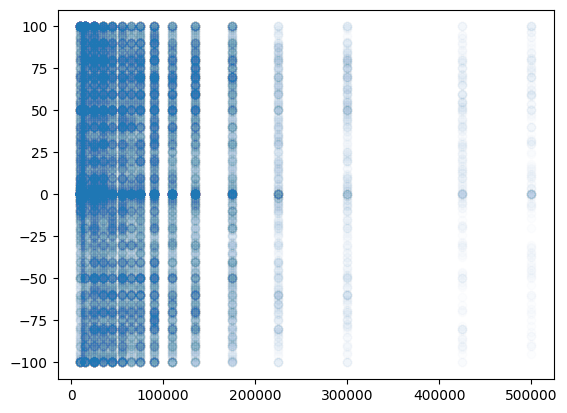

In [9]:
plt.scatter(income2022U,affiliation2022U,alpha=.01)

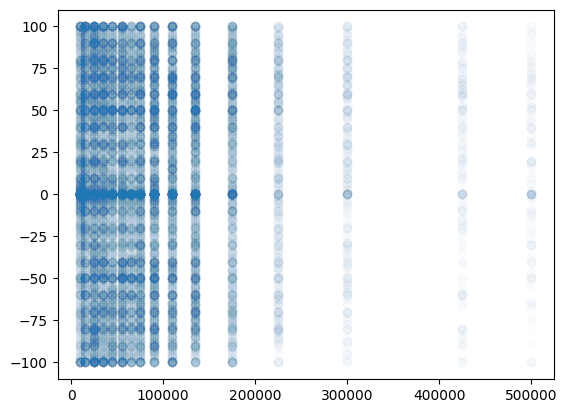

In [10]:
plt.scatter(income2024U,affiliation2024U,alpha=.01)

Income is on the x axis and political affiliation is on the y axis. Negative is Republican and positive is Democrat.

Since everybody gave their income in a range, there are only a few possible income values. This shouldn't be too big of a problem because there are enough of these ranes for the model to fill in the inbetween.

It's hard to see any patterns in this, but there is a high concentration of values at 0. This may indicate the data has a mode at 0 and slowly diffuses out, but it's hard to tell since everything is so dense.

## Normal Model

Below is the Normal model coded as explained above for 2022.

In [26]:
with pm.Model() as model_inc:

    #priors for the linear part of our model
    α = pm.Normal("α", mu=0, sigma=20)
    β = pm.Normal("β", mu=0, sigma=.0005)

    #this is the linear part of our model
    μ = pm.Deterministic("μ", α + β * income2022U)

    #prior for the standard deviation of our likelihood
    #Cauchy is a T dist with nu = 1
    σ = pm.HalfNormal("σ", 50)

    #likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=affiliation2022U)

    #inference data object
    idata_inc = pm.sample()

Output()

Output()

Output()

Text(0, 0.5, 'political affiliation')

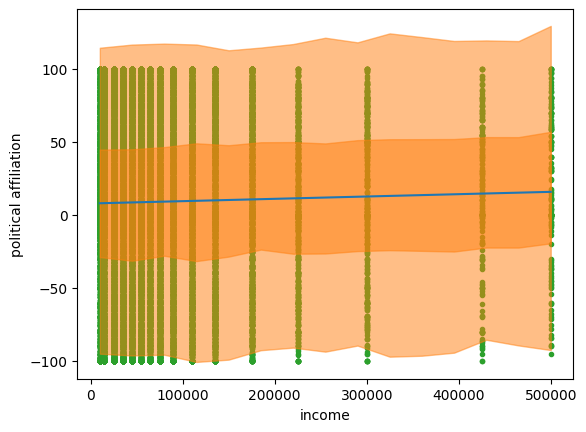

In [27]:
pm.sample_posterior_predictive(idata_inc, model=model_inc,  extend_inferencedata=True)
#plots the posterior predictive distribution

#grabs the expected line, or line of best fit formula
mean_line = idata_inc.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
temperatures = np.random.normal(income2022U, 0.01)
idx = np.argsort(temperatures)
x = np.linspace(temperatures.min(), temperatures.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_inc.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(temperatures[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(income2022U, affiliation2022U, "C2.", zorder=-3)
ax.plot(np.array(income2022U)[idx], mean_line[idx], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("income")
ax.set_ylabel("political affiliation")

The mean line, as expected, is around 0. It is slightly above but that could be due to bias in data collection. The line is relatively flat but it does increase slightly.

Below is the model for 2024

In [28]:
with pm.Model() as model_inc4:

    #priors for the linear part of our model
    α = pm.Normal("α", mu=0, sigma=20)
    β = pm.Normal("β", mu=0, sigma=.0005)

    #this is the linear part of our model
    μ = pm.Deterministic("μ", α + β * income2024U)

    #prior for the standard deviation of our likelihood
    #Cauchy is a T dist with nu = 1
    σ = pm.HalfNormal("σ", 50)

    #likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=affiliation2024U)

    #inference data object
    idata_inc4 = pm.sample()

Output()

Output()

Output()

Text(0, 0.5, 'political affiliation')

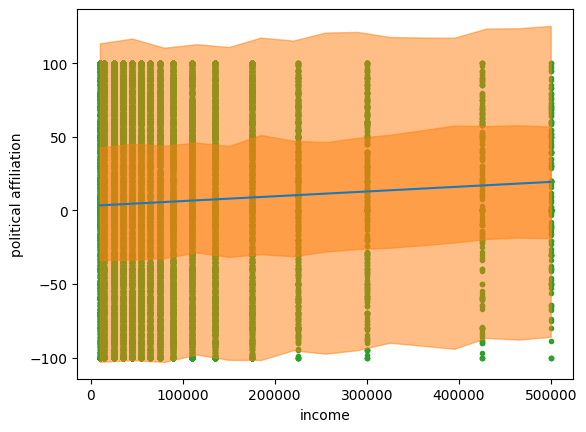

In [29]:
pm.sample_posterior_predictive(idata_inc4, model=model_inc4,  extend_inferencedata=True)
#plots the posterior predictive distribution

#grabs the expected line, or line of best fit formula
mean_line = idata_inc4.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
temperatures = np.random.normal(income2024U, 0.01)
idx = np.argsort(temperatures)
x = np.linspace(temperatures.min(), temperatures.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_inc4.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(temperatures[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(income2024U, affiliation2024U, "C2.", zorder=-3)
ax.plot(np.array(income2024U)[idx], mean_line[idx], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("income")
ax.set_ylabel("political affiliation")

The mean line for 2024 is also centered near 0, while people who make over %500k are clearly leaning Democrat. However, there is a much clearer increase in the 2024 data.

array([<Axes: title={'center': 'α'}>, <Axes: title={'center': 'β'}>],
      dtype=object)

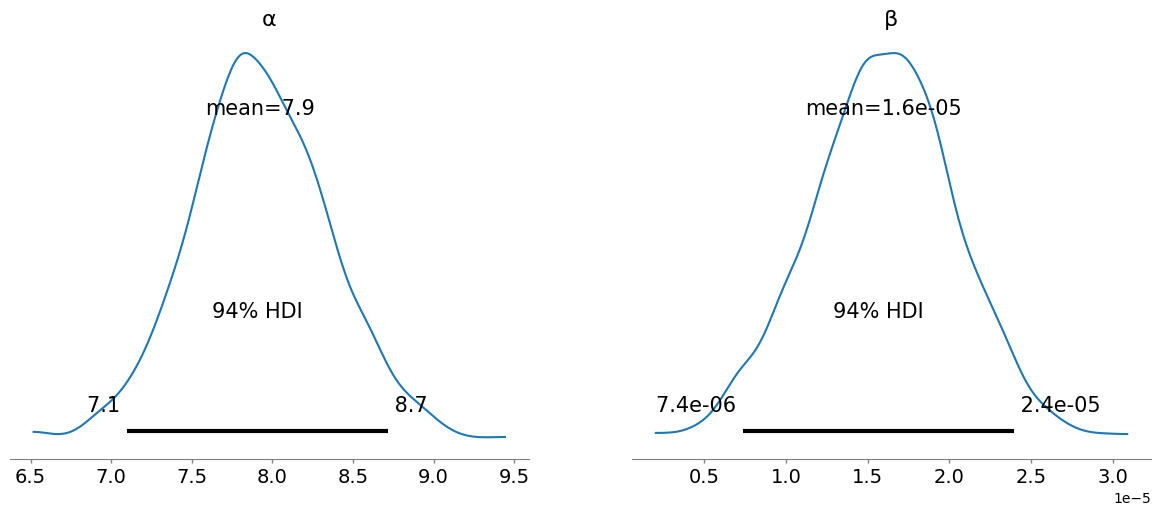

In [30]:
az.plot_posterior(idata_inc, var_names=['α','β'])

array([<Axes: title={'center': 'α'}>, <Axes: title={'center': 'β'}>],
      dtype=object)

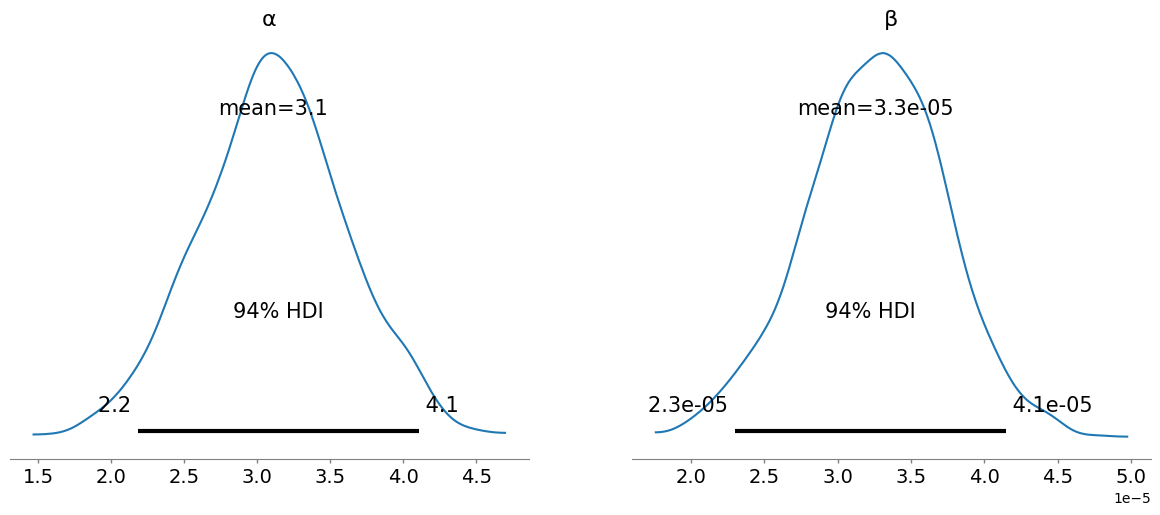

In [31]:
az.plot_posterior(idata_inc4, var_names=['α','β'])

The top plots are 2022 and the bottom are 2024. The slope of the increase in 2024 is about twice the of the slope of the increase in 2022. On the other hand, in 2022 the y intercept is about double that of the intercept in 2024. It is also important to note that the 94% of the HDIs barely touch, so they could possibly still be the same.

<Axes: xlabel='y_pred'>

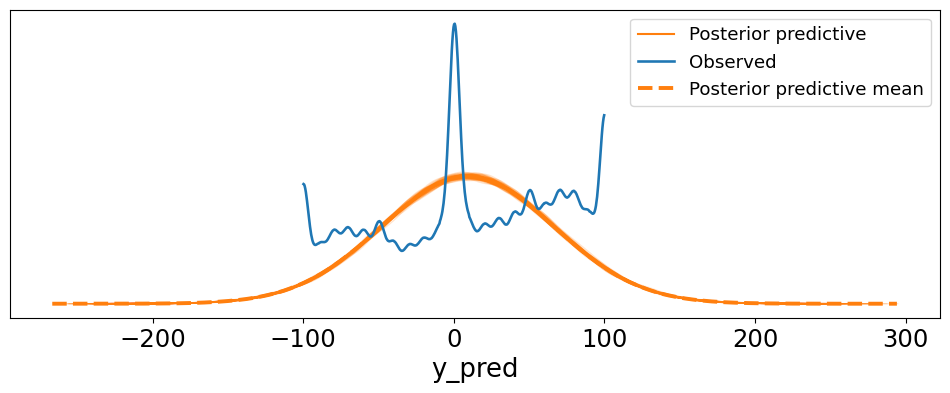

In [32]:
az.plot_ppc(idata_inc, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

<Axes: xlabel='y_pred'>

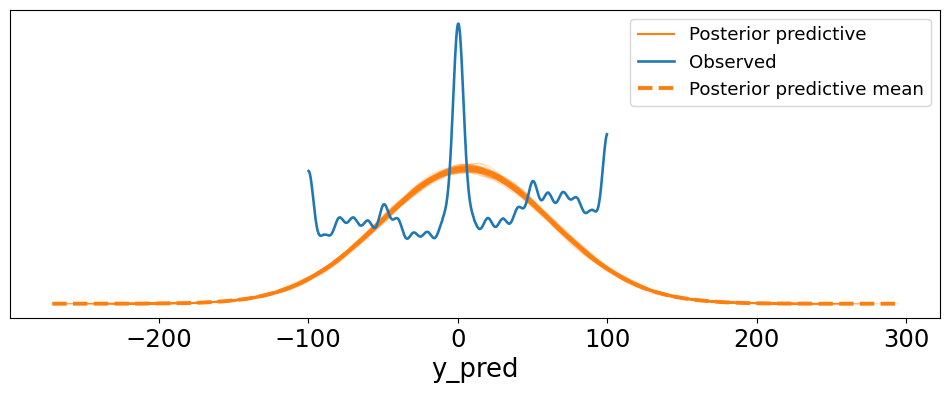

In [34]:
az.plot_ppc(idata_inc4, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

The top graph is 2022 and the bottom graph is 2024.

As expected, the normal distribution performs poorly in the ppc. It predicts values outside of the possible range so its predictions have no way of being correct. Though, I would argue even though the normal distribution performs poorly at predictions its ok as a measure of central tendency. The only aspect the model could make better was where the center was, so I'm guessing its mean line would be similar to a better model's mean line.

I do alo want to point out that the 2022 and 2024 data look strangely similar. The peaks in the ppc look to be in about the same spots and about the same heights. My guess for this is that this is due to who the data collectors are questioning and the sheer amount of data makes the data collected be almost the same.

Lastly, I think a non transfored linear model was ok here. Maybe a log or root transformation would be better, but it seems unneccesary for a model I just used as a test.

## Beta Model

### Beta priors

For my Beta likelihood, I'm going to run a linear fit (an alpha and beta) for both the alpha and beta parameters of the Beta likelihood. From my assumptions, I'll keep the mean at no political affiliation but still have a large variability for the model to change this if needed. Also, since the ppc shows that the data is somewhat flat, I'm going to use low valued priors for alpha and beta. A Beta distribution is uniform when alpha=1 and beta=1 so that will be my assumption here.

My priors for the alpha (y intercept) of the parameters alpha and beta will be the same. My priors for beta will also be the same. If alpha=beta then the mean is in the center. This is what I want.

My prior for the alphas will be a normal distribution with a mean of 1 and a sigma of .25.

<Axes: >

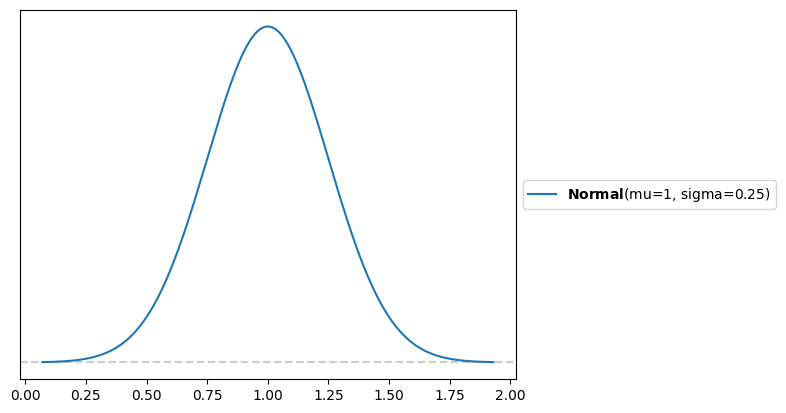

In [6]:
pz.Normal(mu=1,sigma=.25).plot_pdf()

My prior for the betas will be a normal distribution with a mean of 0 and a sigma of .00001. .00001 equates to a change of 1 with $100k so this is a very weak prior.

<Axes: >

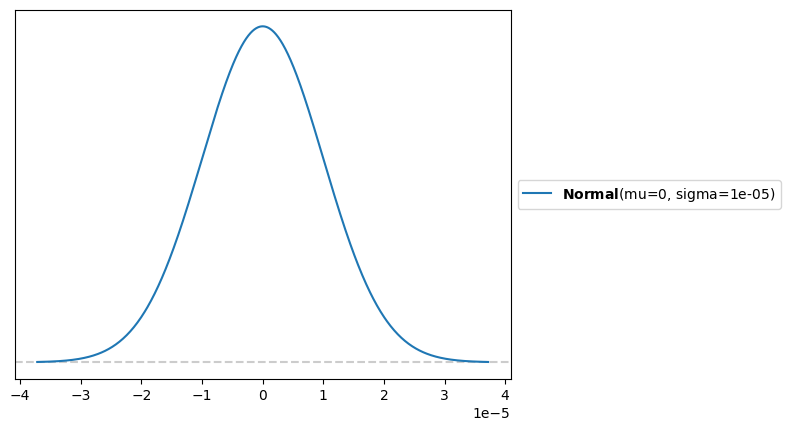

In [7]:
pz.Normal(mu=0,sigma=.00001).plot_pdf()

### Beta Model Running

The below two blocks of code are the 2022 beta model and 2024 beta model as detailed above.

In [11]:
with pm.Model() as model_beta22: # 2022 data

    #priors for the linear part of our model
    α_alpha = pm.Normal("α_alpha", mu=1, sigma=.25)
    β_alpha = pm.Normal("β_alpha", mu=0, sigma=.00001)

    α_beta = pm.Normal("α_beta", mu=1, sigma=.25)
    β_beta = pm.Normal("β_beta", mu=0, sigma=.00001)

    #this is the linear part of our model
    μ_alpha = pm.Deterministic("μ_alpha", α_alpha + β_alpha * income2022U)
    μ_beta = pm.Deterministic("μ_beta", α_beta + β_beta * income2022U)


    # just for looking at afterwards
    μ = pm.Deterministic("μ", (α_alpha + β_alpha * income2022U) / (α_alpha + β_alpha * income2022U + α_beta + β_beta * income2022U))


    #likelihood
    y_pred = pm.Beta("y_pred", alpha=μ_alpha, beta=μ_beta, observed=(np.array(affiliation2022U)+101)/202)

    #inference data object
    idata_beta22 = pm.sample()

Output()

Output()

In [20]:
with pm.Model() as model_beta24: # 2024 data

    #priors for the linear part of our model
    α_alpha = pm.Normal("α_alpha", mu=1, sigma=.25)
    β_alpha = pm.Normal("β_alpha", mu=0, sigma=.00001)

    α_beta = pm.Normal("α_beta", mu=1, sigma=.25)
    β_beta = pm.Normal("β_beta", mu=0, sigma=.00001)

    #this is the linear part of our model
    μ_alpha = pm.Deterministic("μ_alpha", α_alpha + β_alpha * income2024U)
    μ_beta = pm.Deterministic("μ_beta", α_beta + β_beta * income2024U)


    # just for looking at afterwards
    μ = pm.Deterministic("μ", (α_alpha + β_alpha * income2024U) / (α_alpha + β_alpha * income2024U + α_beta + β_beta * income2024U))


    #likelihood
    y_pred = pm.Beta("y_pred", alpha=μ_alpha, beta=μ_beta, observed=(np.array(affiliation2024U)+101)/202)

    #inference data object
    idata_beta24 = pm.sample()

Sampling chain 1, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:08:10

Output()

Text(0, 0.5, 'political affiliation')

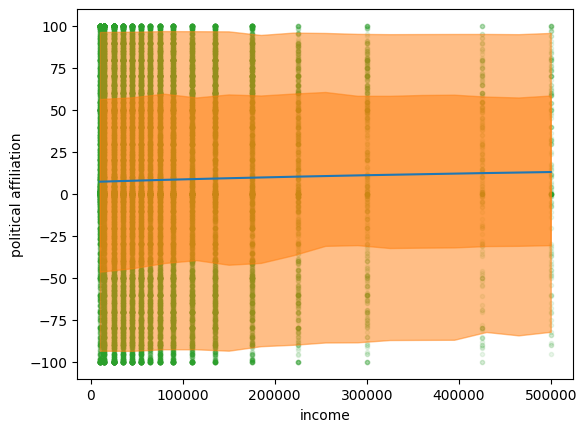

In [16]:
pm.sample_posterior_predictive(idata_beta22, model=model_beta22,  extend_inferencedata=True)
#plots the posterior predictive distribution

#grabs the expected line
mean_line = idata_beta22.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
temperatures = np.random.normal(income2022U, 0.01)
idx = np.argsort(temperatures)
x = np.linspace(temperatures.min(), temperatures.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_beta22.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
) * 202 - 101
y_hat_bounds = iter(
    [
        PchipInterpolator(temperatures[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(np.array(income2022U), np.array(affiliation2022U), "C2.", zorder=-3, alpha=.1)
ax.plot(np.array(income2022U)[idx], mean_line[idx]*202-101, c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("income")
ax.set_ylabel("political affiliation")

Similar to the normal prediction for 2022, the mean is slightly leaning Democrat and is slightly increasing. Also, the variance seems to slightly decrease as income increases.

Output()

Text(0, 0.5, 'political affiliation')

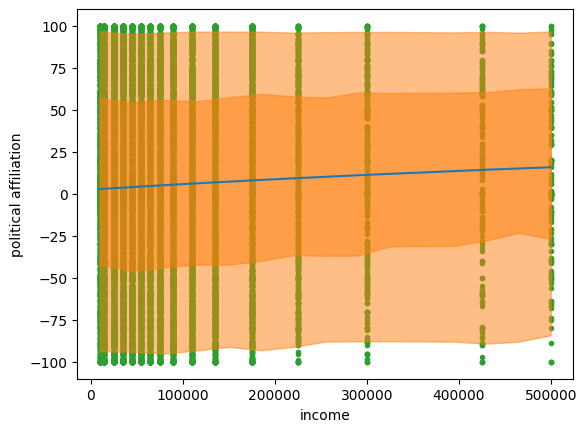

In [24]:
pm.sample_posterior_predictive(idata_beta24, model=model_beta24,  extend_inferencedata=True)
#plots the posterior predictive distribution

#grabs the expected line
mean_line = idata_beta24.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
temperatures = np.random.normal(income2024U, 0.01)
idx = np.argsort(temperatures)
x = np.linspace(temperatures.min(), temperatures.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_beta24.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
) * 202 - 101
y_hat_bounds = iter(
    [
        PchipInterpolator(temperatures[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(np.array(income2024U), np.array(affiliation2024U), "C2.", zorder=-3)
ax.plot(np.array(income2024U)[idx], mean_line[idx]*202-101, c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("income")
ax.set_ylabel("political affiliation")

Again, except for the range, this looks like the normal model. The mean starts around 0 and increases to maybe 15.

array([<Axes: title={'center': 'α_alpha'}>,
       <Axes: title={'center': 'β_alpha'}>,
       <Axes: title={'center': 'α_beta'}>,
       <Axes: title={'center': 'β_beta'}>], dtype=object)

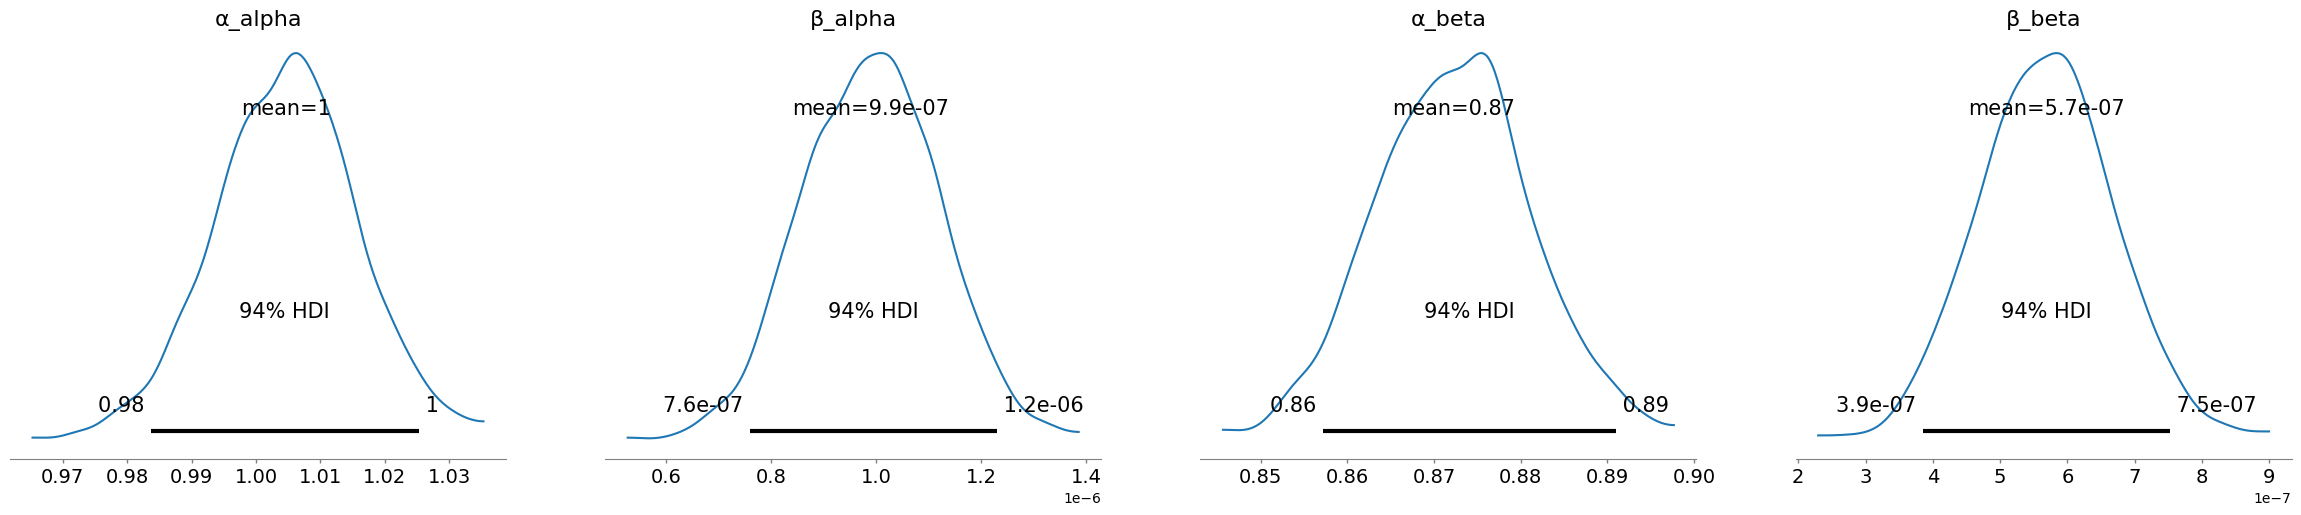

In [13]:
az.plot_posterior(idata_beta22, var_names=['α_alpha','β_alpha','α_beta','β_beta'])

array([<Axes: title={'center': 'α_alpha'}>,
       <Axes: title={'center': 'β_alpha'}>,
       <Axes: title={'center': 'α_beta'}>,
       <Axes: title={'center': 'β_beta'}>], dtype=object)

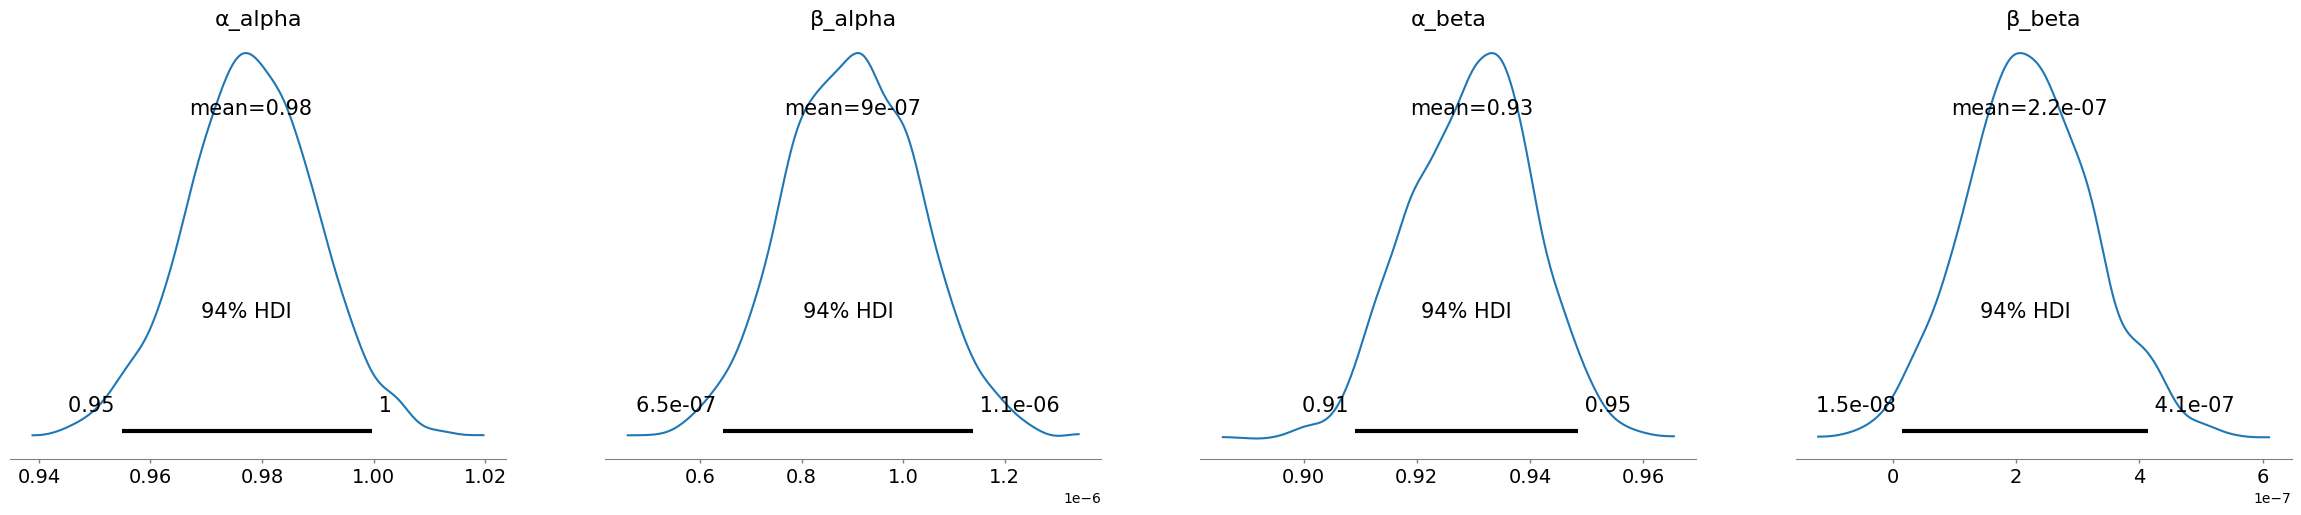

In [25]:
az.plot_posterior(idata_beta24, var_names=['α_alpha','β_alpha','α_beta','β_beta'])

The top sets of graphs is 2022 and the bottom is 2024. α_alpha and α_beta (the intercepts for alpha and beta) are close together in the second sets of plots. This explains why the model starts predicting closer to 0 (the mean would be 0 if they were equal).

β_alpha (the slope of alpha) is about the same for 2022 and 2024. β_beta (the slope of beta), on the other hand, is lower for 2024. The mean of a beta distribution is high when alpha is high and beta is low. The slope of beta being lower in 2024 makes the mean of 2024 be higher. (The mean of a beta distribution is alpha / (alpha + beta)). Again, like in the normal distribution, it is important to note that the 94% HDIs barely touch. This means it is possible they are the same, but I its very unlikely.

Both alpha and beta have positive slopes for both years. This is what causes the variance to decrease. A higher alpha and beta means a more confident distribution and a lower variance.

#### Beta Visualization

Because of all the alpha and betas being confusing, I'm going to graph what they mean below. These graphs aren't the actual predictions but are a visualization of what the predictions may look like. The actual prediction is the amalgamation of many beta distributions so while it may have the same peaks and dips, the general shape would be very different, especially for $500k.

<Axes: >

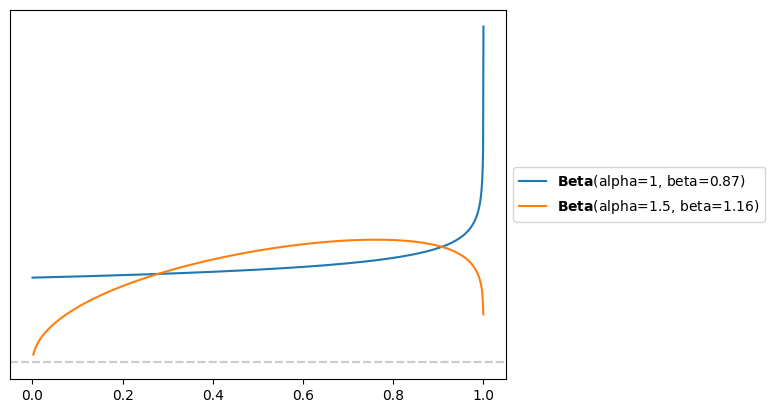

In [40]:
pz.Beta(alpha=1,beta=.87).plot_pdf()
pz.Beta(alpha=1 + 9.9 * 10**(-7) * 500_000, beta=.87 + 5.7 * 10**(-7)*500_000).plot_pdf()

The above graphs are for 2022. The blue curve is a possible distribution of political affilation for those making no money. The orange curve is a possible distribution for those making over $500,000 a year.

The model gets more confident as income increases and narrows in on being more democratic. The large bump in the blue graph is probably due to me using an inoptimal model setup.

<Axes: >

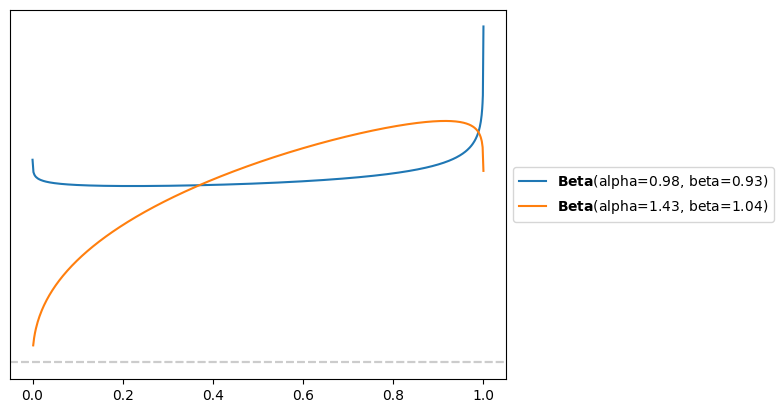

In [44]:
pz.Beta(alpha=.98,beta=.93).plot_pdf()
pz.Beta(alpha=.98 + 9 * 10**(-7) * 500_000, beta=.93 + 2.2 * 10**(-7)*500_000).plot_pdf()

This is 2024. Similar to the previos graph, blue is people who make no money and orange is people who make 500k a year. The curves are just possible predictions and only roughly represent the model.

Like the other graph, the curve gets more confident with more money and gives a big bump over strongly democrat for $500k.

#### Beta model analysis

<Axes: xlabel='y_pred'>

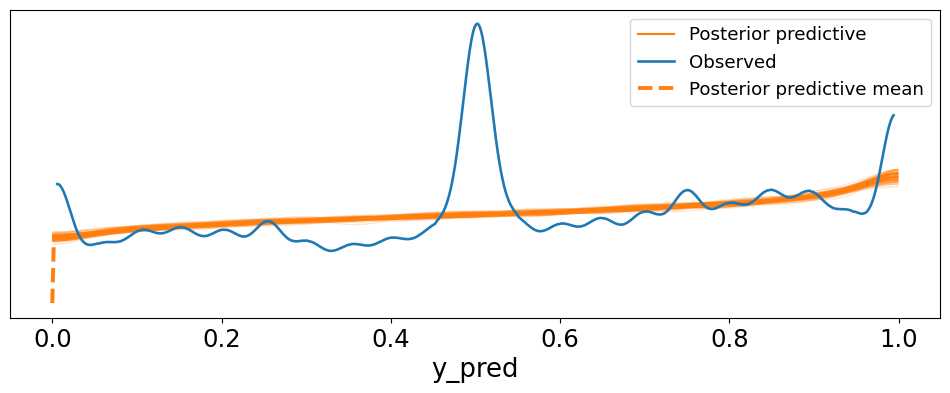

In [14]:
az.plot_ppc(idata_beta22, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

<Axes: xlabel='y_pred'>

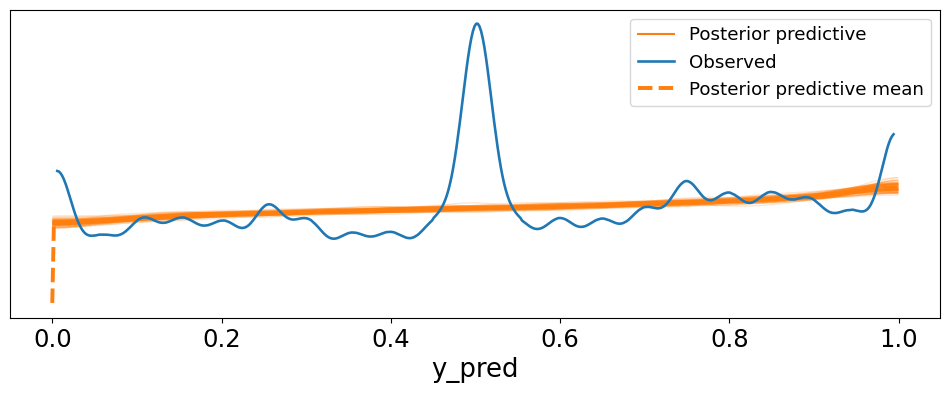

In [23]:
az.plot_ppc(idata_beta24, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

The ppcs look better than the normal ppcs. It doesn't model all of the jumping but gives an almost uniform curve. Looking at the observed data though, it looks almost too similar. All the jumps are in the same spot. There may have been a problem with how the data was collected and I'm guessing the peak at the center might just be straight 0s. If this was the case, then the model would struggle to predict just a single jump.

(array([ 498.,  102.,   68.,   54.,   60.,   86.,   69.,   55.,   68.,
          74.,  217.,  102.,   96.,   71.,   63.,  119.,   56.,   65.,
          61.,   97.,  344.,  144.,   80.,   66.,   63.,  183.,   71.,
          70.,   60.,  115.,  320.,  113.,   77.,   75.,   76.,  158.,
          68.,   67.,   89.,   86.,  326.,  118.,   76.,   62.,   57.,
         138.,   55.,   61.,   75.,  117.,  470.,  134.,   87.,   68.,
          78.,  139.,   73.,   78.,   78.,  126.,  342.,  106.,   72.,
          57.,   51.,  123.,   44.,   58.,   58.,   76.,  284.,  113.,
          69.,   46.,   54.,  133.,   66.,   67.,   75.,   88.,  269.,
          77.,   71.,   64.,   59.,   95.,   62.,   66.,   83.,  107.,
         318.,   88.,   81.,   82.,   92.,  176.,  116.,  142.,  166.,
         284., 1946.,  276.,  181.,  140.,  123.,  169.,   91.,   78.,
         105.,  125.,  277.,   86.,   85.,   63.,   63.,  139.,   66.,
          72.,   89.,  116.,  337.,  105.,   86.,   59.,   57.,  164.,
      

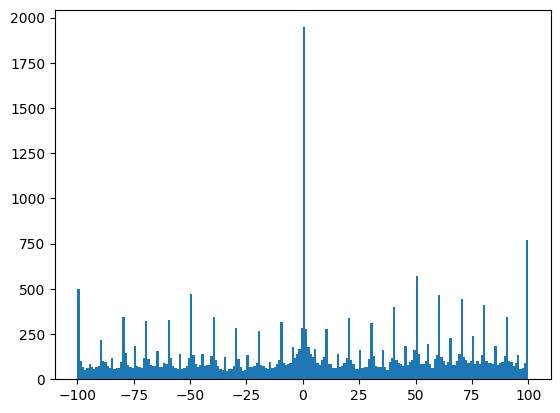

In [19]:
plt.hist(affiliation2022U,bins=200)

Above is a histogram for political affiliation in 2022. All the jumps seem to be at increments of 5 with the biggest jumps at increments of 10. The biggest peaks of the graph are at -100, -50, 0, 50, and 100.

The data seems to have been collected with a heavy bias for nice numbers. There would be no easy way to exactly model this, and I think the beta model did an ok job. Other than at 0, the data does look pretty uniform. If I were to continue trying to model this, I would use a mixture distribution with my current Beta distribution and a normal distribution centered at 0 to catch the big peak.

I think using a non transformed linear model is fine. While the mean line may be a curve, this doesn't neccesarily mean the parameters alpha and beta are curved with change in income. How alpha and beta should be curved is somewhat cryptic, and I think just using a normal linear mean line is fine.

Overall, I think the Beta model did a good job. It seems to model the uniformity of political affiliation and changes variability as income changes.

# Conclusion


The beta model ended up pretty good while the normal model ended up pretty bad. They both agreed upon the average leaning more Democrat as income increased, but the normal model failed to give predictions within the correct range. The normal model would also fail as income gets high, while the beta model may give a bad prediction but it would still work.

The main reason for the beta's model success was it had the correct support. Affiliation was scored from -100 (strongly Republican) to 100 (strongly Democrat). Most distributions have an infinite support, but a beta distribution doesn't so it can be changed to have the correct support.

The models also all predicted that the slope of 2024 was higher, meaning the mean became Democratic faster with change in income in 2024 than it did in 2022. My guess for this would be that people get more polarized as an election comes up, so the difference was stretched further. If most affiliation values become twice as extreme, then the slope would likewise become twice as high.

A non transformed linear model worked out fine for the normal and beta models. It's not clear exactly how the parameters in beta should change with change in income and the posterior was good enough that just using a normal linear model is fine.

Also, just modelling the curve was fine becasue I had enough data.

My explanation for my results is Democrats are more urban and go to college more. Urban cities typically pay more on average and going further in school opens more doors to make money. I won't try to explain why this is, but I will say this is the best explanation I can give for my results.

In [1]:
print("In 2024, the normal model predicts the mean affiliation of those with a one billion dollar income to be: " + str(3.1 + 3.3 * 10**(-5) * 1_000_000_000))

In 2024, the normal model predicts the mean affiliation of those with a one billion dollar income to be: 33003.1


33003 is a bit outside the range of [-100,100].

In [9]:
print("In 2024, the beta model predicts the mean affiliation of those with a one billion dollar income to be: " + str(100 * (.98 + 9 * 10**(-7) * 1_000_000_000) / ((.98 + 9 * 10**(-7) * 1_000_000_000) + ( .93 + 2.2 * 10**(-7) * 1_000_000_000))))

In 2024, the beta model predicts the mean affiliation of those with a one billion dollar income to be: 80.30768956511663


While 80 is actually in the range, I'd think that billionaires aren't that strongly Democrat as a whole.